In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, ttest_ind
from itertools import groupby
import matplotlib.pyplot as plt

In [2]:
!which python

/usr/licensed/anaconda3/2022.5/bin/python


In [3]:
def get_member_ratio(datadf, metrics, thre_cnt=1, skip=[], mode='ks'):
    sample2mem = []
    for idx, row in datadf.iterrows():
        sample2mem.append(np.sum([row[m] for m in (set(metrics) - set(skip))]))
    
    members_bool = np.asarray(sample2mem) >= thre_cnt

    if mode == 'ks': # ks distance
        _, pvalue = ks_2samp(members_bool,[1 for i in range(10000)] , mode='asymp')
    elif mode == 't': # majority
        if members_bool.mean() == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
    elif mode == 'max':
        if max(members_bool) == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
    elif mode == 'majority':
        if members_bool.sum() > members_bool.size // 2:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
         

    return np.sum(members_bool) / len(datadf), pvalue

In [4]:
!pwd

/scratch/gpfs/aalag/DataAuditingThesis


In [5]:
class TableObj:
    def __init__(self, table, expt, mode, size, data, metrics):
        self.table = table
        self.expt = expt
        self.mode = mode
        self.size = size
        self.data = data
        self.metrics = metrics

In [6]:
def compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup):
    tables = []
    if data == ['MNIST']:
        cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'SVHN']
    elif data == ['Location']:
        cols = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']
    elif data == ['COVIDx']:
        cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Chest']
    
    EMA_res_table = pd.DataFrame(columns=cols, index=[f'k={100-k}' for k in klist])
    for i, expt in enumerate(experiments):
        for caldata in data:
            for size in sizes:
                for mode in modes:
                    print(f'-----  Query_size:{size} \t Cal data:{caldata}  -----')
                    for k in klist:
                        logname = f'caldata={caldata}_epoch={epoch}_k={k}_calsize=10000'
                        for fold in range(7):
                            if caldata == 'Location' and fold == 0:
                                continue
                            queryset = pd.read_csv(f'./saves_new/{expt}/EMA_{caldata}/query_set/binarized_{logname}_fold{fold}.csv') 
                            if fold == 0 or fold == 6:
                                ground_truth = 'Query is not in base'
                            else:
                                ground_truth = 'Query is in base'
                            t, pv = get_member_ratio(queryset[:size], metrics, mode=mode)

                            EMA_res = np.around(pv, decimals=2)
                            if fold == 0 and caldata == 'MNIST':
                                EMA_res_table['SVHN'][f'k={100-k}'] = EMA_res
                            elif fold == 0 and caldata == 'COVIDx':
                                EMA_res_table['Chest'][f'k={100-k}'] = EMA_res
                            elif caldata == 'Location':
                                EMA_res_table[f'L{fold}'][f'k={100-k}'] = EMA_res
                            elif caldata == 'MNIST':
                                EMA_res_table[f'M{fold}'][f'k={100-k}'] = EMA_res
                            elif caldata == 'COVIDx':
                                EMA_res_table[f'C{fold}'][f'k={100-k}'] = EMA_res

                    if expt == "":
                        table_obj = TableObj(EMA_res_table, "Control EMA", mode, size, caldata, metrics)
                    else:
                        table_obj = TableObj(EMA_res_table, expt, mode, size, caldata, metrics)
                    tables.append(table_obj)
                    print(EMA_res_table, '\n')
                    
                    EMA_res_table = pd.DataFrame(columns=cols, index=[f'k={100-k}' for k in klist])

    return tables

In [15]:
### Run EMA on the benchmark datasets, Table 2.b and Table 6
# experiments = ["", "re-dropout0.1", "re-dropout0.2", "re-dropout0.3", "re-dropout0.4", "re-dropout0.5", "re-dropout0.6","re-dropout0.7","re-dropout0.8", "re-dropout0.9", "re-plateau1"]
# experiments = ["LocDropout0.0", "LocDropout0.1", "LocDropout0.2", "LocDropout0.3", "LocDropout0.4", "LocDropout0.5", "LocDropout0.6", "LocDropout0.7", "LocDropout0.8", "LocDropout0.9"]
# experiments = ["LocDropout0.0", "MemGuard_mixup", "MemGuard_noMixup"]
# experiments = ["Location_base", "Location_sparsity0.1", "Location_sparsity0.2", "Location_sparsity0.3",
#               "Location_sparsity0.4", "Location_sparsity0.5", "Location_sparsity0.6", "Location_sparsity0.7",
#                "Location_sparsity0.8", "Location_sparsity0.9"]
# experiments = ["Location_base", "Location_sparsity0.65", "Location_sparsity0.725", "Location_sparsity0.75", "Location_sparsity0.775"]
# experiments = ["MNIST_base", "MNIST_sparsity0.625", "MNIST_sparsity0.65", "MNIST_sparsity0.675"]
# experiments = ["Location_base_redo", "Location_base", "LocDropout0.1_redo", "LocDropout0.2_redo", "LocDropout0.3_redo",
#               "LocDropout0.4_redo", "LocDropout0.5_redo", "LocDropout0.6_redo", "LocDropout0.7_redo",
#               "LocDropout0.8_redo", "LocDropout0.9_redo"]
# experiments = ["MNIST_base_redo", "dropout0.1_redo", "dropout0.2_redo", "dropout0.3_redo", "dropout0.4_redo",
#               "dropout0.5_redo", "dropout0.6_redo", "dropout0.7_redo", "dropout0.8_redo", "dropout0.9_redo"]
# experiments = ["MNIST_base_redo", "MNIST_sparsity0.1_redo", "MNIST_sparsity0.2_redo", "MNIST_sparsity0.3_redo",
#                "MNIST_sparsity0.4_redo", "MNIST_sparsity0.5_redo", "MNIST_sparsity0.625_redo", "MNIST_sparsity0.65_redo",
#               "MNIST_sparsity0.675_redo", "MNIST_sparsity0.6_redo", "MNIST_sparsity0.7_redo", "MNIST_sparsity0.8_redo",
#               "MNIST_sparsity0.9_redo"]

# experiments = ["Location_base_redo", "Location_sparsity0.1_redo", "Location_sparsity0.2_redo", "Location_sparsity0.3_redo",
#               "Location_sparsity0.4_redo", "Location_sparsity0.5_redo", "Location_sparsity0.6_redo",
#                "Location_sparsity0.65_redo", "Location_sparsity0.7_redo", "Location_sparsity0.725_redo", "Location_sparsity0.75_redo",
#               "Location_sparsity0.775_redo", "Location_sparsity0.8_redo", "Location_sparsity0.9_redo"]

# experiments = ["MNIST_base_50", "plateau10_redo", "plateau1_redo", "plateau20_redo", "plateau5_redo"]
# experiments = ["MNIST_base_redo", "MNIST_base_50"]
# experiments = ["Location_base_redo", "MemGuard_mixup_redo", "MemGuard_noMixup_redo"]
# experiments = ["COVIDx_base", "COVIDx_sparsity0.1", "COVIDx_sparsity0.2", "COVIDx_sparsity0.3",
#               "COVIDx_sparsity0.4", "COVIDx_sparsity0.5", "COVIDx_sparsity0.6", "COVIDx_sparsity0.7",
#               "COVIDx_sparsity0.8", "COVIDx_sparsity0.9"]

# experiments = ["MNIST_base_50", "Lenet_MNIST", "Lenet_MNIST0.1", "Lenet_MNIST0.2",
#               "Lenet_MNIST0.3", "Lenet_MNIST0.4", "Lenet_MNIST0.5", "Lenet_MNIST0.6",
#               "Lenet_MNIST0.7", "Lenet_MNIST0.8", "Lenet_MNIST0.9"]

# experiments = ["Lenet_MNIST", "Lenet_sparsity0.1", "Lenet_sparsity0.2", "Lenet_sparsity0.3",
#               "Lenet_sparsity0.4", "Lenet_sparsity0.5", "Lenet_sparsity0.6",
#               "Lenet_sparsity0.7", "Lenet_sparsity0.8", "Lenet_sparsity0.9"]

experiments = ["COVIDx_base", "COVIDx_dropout0.0", "COVIDx_dropout0.1", "COVIDx_dropout0.2",
              "COVIDx_dropout0.3", "COVIDx_dropout0.4", "COVIDx_dropout0.5", "COVIDx_dropout0.6",
              "COVIDx_dropout0.7", "COVIDx_dropout0.8", "COVIDx_dropout0.9"]

epoch = 50
# epoch = 200

# epochs = [200, 50]
# epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

metrics = ['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits']

klist = [0, 10, 20, 30, 40, 50]
sizes = [2000, 500, 200, 50, 20, 5]
# data = ['MNIST']
# data = ['Location']
data = ['COVIDx']
mixup = False
modes = ['t']

In [16]:
metric_list = [['correctness'], ['confidence'], ['entropy'], ['modified entropy'], ['scaled logits'], ['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits'], ['correctness', 'confidence'], ['correctness', 'entropy'], ['correctness', 'modified entropy'], ['correctness', 'scaled logits']]

In [17]:
# all_tables = []
# for metrics in metric_list:
#     all_tables.extend(compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup, no_svhn=True))
tables = compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.01   0.0
k=90   1  1  1  1  1  0.01   0.0
k=80   1  1  1  1  1  0.08  0.01
k=

         C1    C2    C3    C4    C5   C6 Chest
k=100  0.03  0.03  0.32  0.05  0.32  0.0   0.0
k=90   0.03  0.03  0.32  0.05  0.32  0.0   0.0
k=80   0.03  0.03  0.32  0.05     1  0.0   0.0
k=70   0.05  0.05  0.32  0.32  0.32  0.0   0.0
k=60   0.03  0.05  0.32  0.08     1  0.0   0.0
k=50      1  0.32  0.32     1     1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5   C6 Chest
k=100  0.05  0.16  0.32  0.16  0.32  0.0   0.0
k=90   0.16  0.05     1  0.16     1  0.0   0.0
k=80   0.08  0.16  0.32  0.05     1  0.0   0.0
k=70   0.16  0.16  0.32     1  0.32  0.0   0.0
k=60   0.08  0.05  0.32  0.16     1  0.0   0.0
k=50      1     1     1     1     1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
         C1    C2    C3    C4 C5   C6 Chest
k=100     1  0.32     1     1  1  0.0   0.0
k=90      1  0.16     1  0.32  1  0.0   0.0
k=80   0.16  0.32     1  0.16  1  0.0   0.0
k=70   0.32     1     1     1  1  0.0   0.0
k=60   0.16  0.16  0.32 

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0  0.16 

-----  Query_size:500 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0  0.32 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1    C2    C3    C4    C5    C6 Chest
k=100  0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90   0.0  0.01  0.04   0.0   0.0   0.0   0.0
k=80   0.0   0.0   0.0  0.01  0.02  0.01  0.01
k=70   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=60   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=50   0.0   0.0   0.0   0.0   0

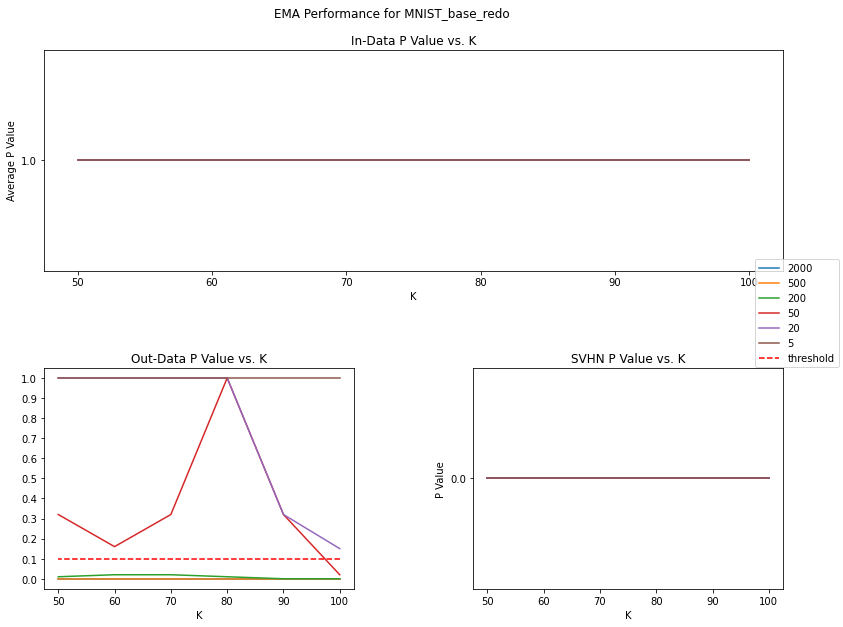

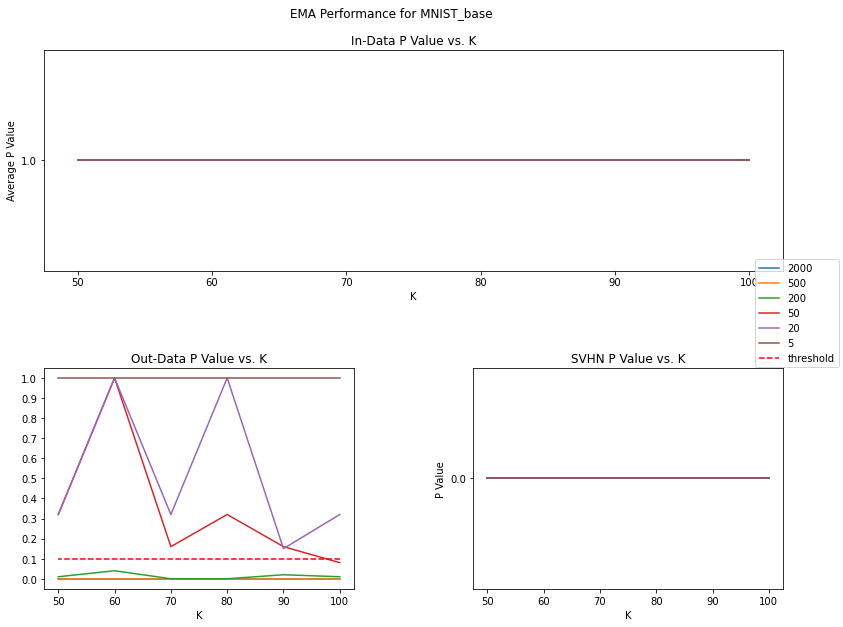

NameError: name 'graph_200' is not defined

In [21]:
graph_tables(tables)
graph_200(tables, 200, 11)

In [12]:
def graph_tables(tables, no_svhn=False):
    # separate line for each query size, two graphs per experiment
    # average M1 - M5 vs M6, SVHN for each k, plot against k
    for expt, group in groupby(tables, key = lambda x: x.expt):
        fig = plt.figure()
        
        axes = []
        if not no_svhn:
            ax1 = plt.subplot(2, 2, (1, 2))
            ax2 = plt.subplot(2, 2, 3)
            ax3 = plt.subplot(2, 2, 4)
            axes = [ax1, ax2, ax3]
        else:
            ax1 = plt.subplot(1, 2, 1)
            ax2 = plt.subplot(1, 2, 2)
            axes = [ax1, ax2]
            
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12.5, 9.5)
        if "re-dropout" in expt:
            expt_string = "Dropout: " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau"
        else:
            expt_string = expt
            
        fig.suptitle("EMA Performance for " + expt_string)
        ax1.set_xlabel("K")
        ax1.set_ylabel("Average P Value")
        ax1.set_title("In-Data P Value vs. K")
        ax2.set_xlabel("K")
        ax2.set_title("Out-Data P Value vs. K")
        if not no_svhn:
            ax3.set_title("SVHN P Value vs. K")
            ax3.set_xlabel("K")
            ax3.set_ylabel("P Value")
            
        for ax in axes:
            ax.set_yticks(np.arange(0, 1.01, 0.1))
        for size_table in group:
            table = size_table.table
            size = size_table.size
            ks = []
            ins = []
            outs = []
            svhns = []
            for index, row in table.iterrows():
                k_val = int(index.strip("k="))
                in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
                out_data = row['M6']
                ks.append(k_val)
                ins.append(np.mean(in_data))
                outs.append(out_data)
                if not no_svhn:
                    svhn = row['SVHN']
                    svhns.append(svhn)
            ax1.plot(ks, ins, label=size)
            ax2.plot(ks, outs, label=size)
            if not no_svhn:
                ax3.plot(ks, svhns, label=size)
        ax2.plot(ks, [0.1]*len(ks), 'r--', label="threshold")
            
        lines = []
        labels = []

        Line, Label = ax2.get_legend_handles_labels()
        # print(Label)
        lines.extend(Line)
        labels.extend(Label)

        fig.legend(lines, labels, loc='center right')

        if "re-dropout" in expt:
            save_str = "Dropout" + expt.strip("re-dropout") + ".png"
        else:
            save_str = expt_string + ".png"
            
        plt.savefig(save_str, format="png", dpi="figure")
        plt.show()
        plt.close()

In [11]:
def ema_accuracy(tables, weights=[100/3, 100/3, 100/3], size=None):
    acc_map = {}
    count_map = {}
    for table in tables:
        if size and table.size != size:
            continue
            
        tab = table.table
        
        if table.data == 'MNIST':
            cols = ['M1', 'M2', 'M3', 'M4', 'M5']
        elif table.data == 'Location':
            cols = ['L1', 'L2', 'L3', 'L4', 'L5']
        elif table.data == 'COVIDx':
            cols = ['C1', 'C2', 'C3', 'C4', 'C5']
        
        in_avg = 0
        for col in cols:
            in_avg += sum(tab[col])/len(tab[col])
        in_avg /= 5
        in_avg *= weights[0]
        
        if table.data == 'MNIST':
            other_col = 'M6'
        elif table.data == 'Location':
            other_col = 'L6'
        elif table.data == 'COVIDx':
            other_col = 'C6'
        
        m6_avg = sum(tab[other_col])/len(tab[other_col])
        m6_avg = (1 - m6_avg) * weights[1]
        
        total = in_avg + m6_avg
        
        if table.data == 'MNIST':
            col = 'SVHN'
            svhn_avg = sum(tab[col])/len(tab[col])
            total += (1 - svhn_avg) * weights[2]
        elif table.data == 'COVIDx':
            col = 'Chest'
            svhn_avg = sum(tab[col])/len(tab[col])
            total += (1 - svhn_avg) * weights[2]
        
        if table.expt in acc_map:
            acc_map[table.expt] += total
            count_map[table.expt] += 1
        else:
            acc_map[table.expt] = total
            count_map[table.expt] = 1
            
        print(table.expt, table.size, total)
    
    for key, value in acc_map.items():
        avg = value / count_map[key]
        print(key + ": " + str(avg))

In [19]:
ema_accuracy(tables, weights=[50, 25, 25])

COVIDx_base 2000 100.0
COVIDx_base 500 100.0
COVIDx_base 200 100.0
COVIDx_base 50 99.16666666666667
COVIDx_base 20 94.58333333333333
COVIDx_base 5 59.0
COVIDx_dropout0.0 2000 91.66666666666669
COVIDx_dropout0.0 500 91.66666666666669
COVIDx_dropout0.0 200 91.66666666666669
COVIDx_dropout0.0 50 91.5
COVIDx_dropout0.0 20 90.66666666666666
COVIDx_dropout0.0 5 76.45833333333334
COVIDx_dropout0.1 2000 90.16666666666669
COVIDx_dropout0.1 500 90.16666666666669
COVIDx_dropout0.1 200 93.48333333333335
COVIDx_dropout0.1 50 90.69166666666666
COVIDx_dropout0.1 20 79.60833333333335
COVIDx_dropout0.1 5 62.458333333333336
COVIDx_dropout0.2 2000 100.0
COVIDx_dropout0.2 500 99.95833333333333
COVIDx_dropout0.2 200 95.16666666666669
COVIDx_dropout0.2 50 82.375
COVIDx_dropout0.2 20 75.70833333333333
COVIDx_dropout0.2 5 64.29166666666667
COVIDx_dropout0.3 2000 89.56666666666666
COVIDx_dropout0.3 500 90.01666666666665
COVIDx_dropout0.3 200 92.03333333333333
COVIDx_dropout0.3 50 85.125
COVIDx_dropout0.3 20 77

In [20]:
data = ['MNIST']
tab_mnist = compute_tables(["MNIST_base", "MNIST_sparsity0.1", "MNIST_sparsity0.2", "MNIST_sparsity0.3", "MNIST_sparsity0.4", "MNIST_sparsity0.5", "MNIST_sparsity0.6", "MNIST_sparsity0.7", "MNIST_sparsity0.8", "MNIST_sparsity0.9"], data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.01  0.0
k=90   1  1  1  1  1  0.02  0.0
k=80   1  1  1  1  1   0.0  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1  0.04  0.0
k=50   1  1  1  1  1  0.01  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.08  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.

      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.01  0.0
k=90   1  1  1  1  1  0.01  0.0
k=80   1  1  1  1  1  0.01  0.0
k=70   1  1  1  1  1  0.04  0.0
k=60   1  1  1  1  1  0.04  0.0
k=50   1  1  1  1  1  0.01  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.32  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.16  0.0
k=60   1  1  1  1  1  0.32  0.0
k=50   1  1  1  1  1  0.04  0.0 

-----  Query_size:20 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1     1  0.0
k=90   1  1  1  1  1  0.32  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.32  0.0
k=60   1  1  1  1  1     1  0.0
k

        M1   M2   M3   M4   M5   M6 SVHN
k=100  0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0  0.0 

-----  Query_size:5 	 Cal data:MNIST  -----
        M1    M2   M3    M4   M5    M6 SVHN
k=100  0.0   0.0  0.0   0.0  0.0  0.04  0.0
k=90   0.0   0.0  0.0  0.04  0.0   0.0  0.0
k=80   0.0   0.0  0.0   0.0  0.0   0.0  0.0
k=70   0.0  0.14  0.0   0.0  0.0   0.0  0.0
k=60   0.0   0.0  0.0  0.04  0.0   0.0  0.0
k=50   0.0   0.0  0.0   0.0  0.0   0.0  0.0 



In [21]:
ema_accuracy(tab_mnist, weights=[50, 25, 25])

NameError: name 'tab_mnist' is not defined

In [60]:
ema_accuracy(tables_plateau)

Control EMA 2000 100.0
Control EMA 500 100.0
Control EMA 200 98.22222222222223
Control EMA 50 84.44444444444444
Control EMA 20 70.44444444444444
Control EMA 5 66.66666666666667
re-plateau20 2000 100.0
re-plateau20 500 100.0
re-plateau20 200 99.11111111111113
re-plateau20 50 84.0
re-plateau20 20 78.94444444444444
re-plateau20 5 70.27777777777779
re-plateau10 2000 100.0
re-plateau10 500 100.0
re-plateau10 200 98.11111111111111
re-plateau10 50 81.77777777777777
re-plateau10 20 78.94444444444444
re-plateau10 5 74.83333333333333
re-plateau5 2000 100.0
re-plateau5 500 100.0
re-plateau5 200 98.11111111111111
re-plateau5 50 86.0
re-plateau5 20 78.94444444444444
re-plateau5 5 75.05555555555556
re-plateau1 2000 100.0
re-plateau1 500 100.0
re-plateau1 200 99.55555555555556
re-plateau1 50 92.44444444444446
re-plateau1 20 74.22222222222223
re-plateau1 5 70.27777777777779


In [25]:
def graph_200(tables, filter_size=200, NUM_COLORS=11, no_svhn=False):
    # three graphs (in, out, svhn) one line per experiment at size = 200 vs K
    fig = plt.figure()
    axes = []
    if not no_svhn:
        ax1 = plt.subplot(2, 2, (1, 2))
        ax2 = plt.subplot(2, 2, 3)
        ax3 = plt.subplot(2, 2, 4)
        axes = [ax1, ax2, ax3]
    else:
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2)
        axes = [ax1, ax2]
        
    filtered = filter(lambda table: table.size == filter_size, tables)
    fig.tight_layout(pad=2.0)
    fig.set_size_inches(12.5, 9.5)

    if NUM_COLORS > 10:
        cm = plt.get_cmap('plasma')
    else:
        cm = plt.get_cmap('hsv')
    
    fig.suptitle("EMA Performance for Query-size 200")
    ax1.set_xlabel("K")
    ax1.set_ylabel("Average P Value")
    ax1.set_title("In-Data P Value vs. K")
    ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    ax2.set_xlabel("K")
    ax2.set_title("Out-Data P Value vs. K")
    ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    if not no_svhn:
        ax3.set_title("SVHN P Value vs. K")
        ax3.set_xlabel("K")
        ax3.set_ylabel("P Value")
        ax3.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for ax in axes:
        ax.set_yticks(np.arange(0, 1.01, 0.1))
        
    
    for size_table in filtered:
        table = size_table.table
        expt = size_table.expt
        if "re-dropout" in expt:
            expt_string = "Dropout " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau" + expt.strip("re-plateau")
        else:
            expt_string = expt
            
        ks = []
        ins = []
        outs = []
        svhns = []
        for index, row in table.iterrows():
            k_val = int(index.strip("k="))
            in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
            out_data = row['M6']
            ks.append(k_val)
            ins.append(np.mean(in_data))
            outs.append(out_data)
            if not no_svhn:
                svhn = row['SVHN']
                svhns.append(svhn)
        ax1.plot(ks, ins, label=expt_string)
        ax2.plot(ks, outs, label=expt_string)
        if not no_svhn:
            ax3.plot(ks, svhns, label=expt_string)

    ax2.plot(np.arange(50, 101, 10), [0.1]*6, 'r--', label="threshold")

    lines = []
    labels = []

    Line, Label = ax2.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

    fig.legend(lines, labels, loc='center right')
    
    plt.savefig("Location_Dropout_200.png", format="png", dpi="figure")
    plt.show()
    plt.close()

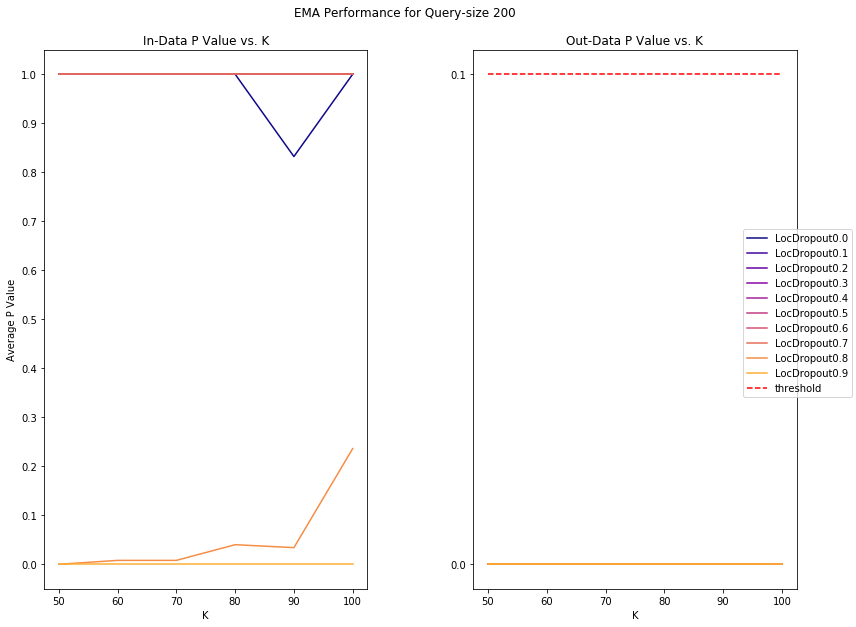

In [27]:
graph_200(tables, 200, 11, True)

In [4]:
### Run EMA on chest X-ray datasets, Table 3.b and Table 7
querydata = 'COVIDx'
expt = "l2"
epoch = 30

EMA_res_table = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CXR'], index=[f'k={100-k}' for k in klist])
for caldata in ['COVIDx']:
    for size in [800, 500, 200, 50, 20, 5]:
        print(f'-----  Query_size:{size} \t Cal data:{caldata}  -----')
        for mode in ['t']:
            print(f'Using {mode}-test')
            for k in klist:
                logname = f'caldata={caldata}_epoch={epoch}_k={k}_calsize=4000'
                for fold in range(7):
                    queryset = pd.read_csv(f'./saves_new/{expt}/EMA_{querydata}/query_set/binarized_{logname}_fold{fold}.csv')  

                    if fold == 0 or fold == 6:
                        ground_truth = 'Query is not in base'
                    else:
                        ground_truth = 'Query is in base'
                    t, pv = get_member_ratio(queryset[:size], skip=['modified entropy'], mode=mode)

                    EMA_res = np.around(pv, decimals=2)
                    if fold == 0:
                        EMA_res_table['CXR'][f'k={100-k}'] = EMA_res
                    else:
                        EMA_res_table[f'C{fold}'][f'k={100-k}'] = EMA_res

            print(EMA_res_table, '\n')
            EMA_res_table = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CXR'], index=[f'k={100-k}' for k in klist])

-----  Query_size:800 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5   C6  CXR
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
Using t-test
      C1 C2 C3 C4 C5    C6   CXR
k=100  1  1  1  1  1  0.01  0.04
k=90   1  1  1  1  1   0.0   0.0
k=80 